<a href="https://colab.research.google.com/github/kiyara52/A028dsDop/blob/main/DsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dagster dagster-webserver pandas numpy scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dagster import asset, Definitions, materialize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [ ]:
@asset
def raw_data():
    return pd.read_csv("AB_NYC_2019.csv")


@asset
def cleaned_data(raw_data):
    df = raw_data.copy()

    # Drop essential NaNs
    df = df.dropna(subset=["price", "room_type", "neighbourhood_group"])

    # Fix numeric NaNs
    df["minimum_nights"] = df["minimum_nights"].fillna(
        df["minimum_nights"].median()
    )

    # Create target
    df["price_category"] = pd.cut(
        df["price"],
        bins=[0, 100, 300, 10000],
        labels=["Cheap", "Medium", "Expensive"]
    )

    df = df.dropna(subset=["price_category"])

    return df



@asset
def features(cleaned_data):
    df = cleaned_data.copy()

    # Handle NaN safely
    df["minimum_nights"] = df["minimum_nights"].fillna(
        df["minimum_nights"].median()
    )

    le1, le2 = LabelEncoder(), LabelEncoder()
    df["room_type_enc"] = le1.fit_transform(df["room_type"])
    df["area_enc"] = le2.fit_transform(df["neighbourhood_group"])

    X = df[["room_type_enc", "area_enc", "minimum_nights"]]
    y = df["price_category"]

    return X, y



@asset
def train_test_data(features):
    X, y = features
    return train_test_split(X, y, test_size=0.2, random_state=42)


@asset
def decision_tree_model(train_test_data):
    X_train, X_test, y_train, y_test = train_test_data
    model = DecisionTreeClassifier(max_depth=5)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    return {"model": model, "accuracy": acc}


@asset
def random_forest_model(train_test_data):
    X_train, X_test, y_train, y_test = train_test_data
    model = RandomForestClassifier(n_estimators=50)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    return {"model": model, "accuracy": acc}


@asset
def logistic_regression_model(train_test_data):
    X_train, X_test, y_train, y_test = train_test_data
    model = LogisticRegression(max_iter=300)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    return {"model": model, "accuracy": acc}


defs = Definitions(
    assets=[
        raw_data,
        cleaned_data,
        features,
        train_test_data,
        decision_tree_model,
        random_forest_model,
        logistic_regression_model,
    ]
)


In [ ]:
result = materialize([
    raw_data,
    cleaned_data,
    features,
    train_test_data,
    decision_tree_model,
    random_forest_model,
    logistic_regression_model,
])


2026-01-31 07:27:27 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - b50a1789-bf3b-463e-ba7b-7b358ba83b9c - 4318 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-01-31 07:27:27 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - b50a1789-bf3b-463e-ba7b-7b358ba83b9c - 4318 - ENGINE_EVENT - Executing steps in process (pid: 4318)
2026-01-31 07:27:27 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - b50a1789-bf3b-463e-ba7b-7b358ba83b9c - 4318 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 07:27:27 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - b50a1789-bf3b-463e-ba7b-7b358ba83b9c - 4318 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 07:27:27 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - b50a1789-bf3b-463e-ba7b-7b358ba83b9c - 4318 - LOGS_CAPTURED - Started capturing logs in process (pid: 4318).
2026-01-31 07:27:27 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - b50

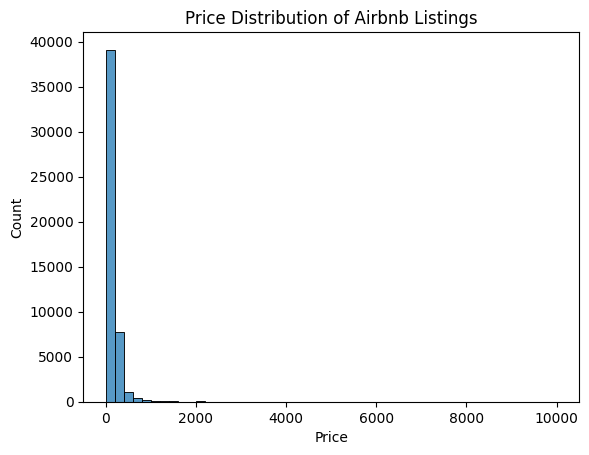

In [ ]:
df = pd.read_csv("AB_NYC_2019.csv")

plt.figure()
sns.histplot(df["price"], bins=50)
plt.title("Price Distribution of Airbnb Listings")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


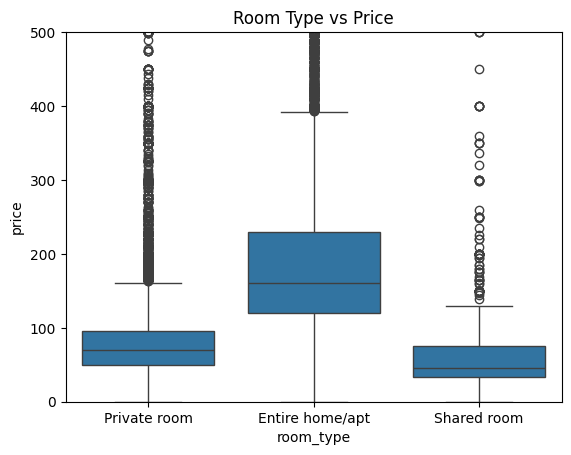

In [ ]:
plt.figure()
sns.boxplot(x="room_type", y="price", data=df)
plt.ylim(0, 500)
plt.title("Room Type vs Price")
plt.show()


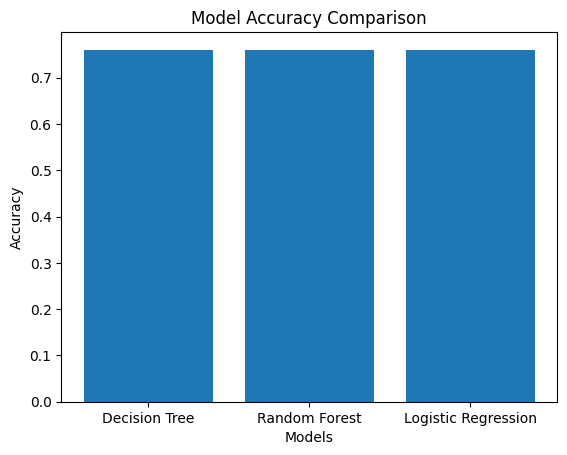

In [ ]:
accuracies = {
    "Decision Tree": result.output_for_node("decision_tree_model")["accuracy"],
    "Random Forest": result.output_for_node("random_forest_model")["accuracy"],
    "Logistic Regression": result.output_for_node("logistic_regression_model")["accuracy"],
}

plt.figure()
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


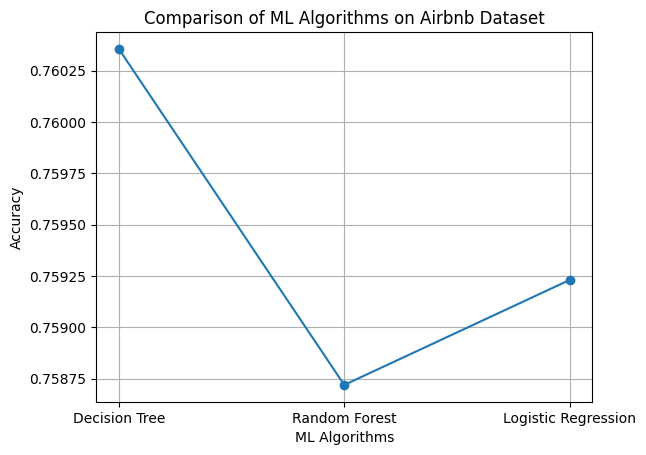

In [ ]:
import matplotlib.pyplot as plt

model_names = [
    "Decision Tree",
    "Random Forest",
    "Logistic Regression"
]

accuracies = [
    result.output_for_node("decision_tree_model")["accuracy"],
    result.output_for_node("random_forest_model")["accuracy"],
    result.output_for_node("logistic_regression_model")["accuracy"]
]

plt.figure()
plt.plot(model_names, accuracies, marker='o')
plt.xlabel("ML Algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of ML Algorithms on Airbnb Dataset")
plt.grid(True)
plt.show()


In [ ]:
dt_acc = result.output_for_node("decision_tree_model")["accuracy"] * 100
rf_acc = result.output_for_node("random_forest_model")["accuracy"] * 100
lr_acc = result.output_for_node("logistic_regression_model")["accuracy"] * 100

print(f"Decision Tree Accuracy      : {dt_acc:.2f}%")
print(f"Random Forest Accuracy      : {rf_acc:.2f}%")
print(f"Logistic Regression Accuracy: {lr_acc:.2f}%")


Decision Tree Accuracy      : 76.04%
Random Forest Accuracy      : 75.87%
Logistic Regression Accuracy: 75.92%


FIRST RUN ACCURACY (%)
Decision Tree      : 76.04
Random Forest      : 75.87
Logistic Regression: 75.92


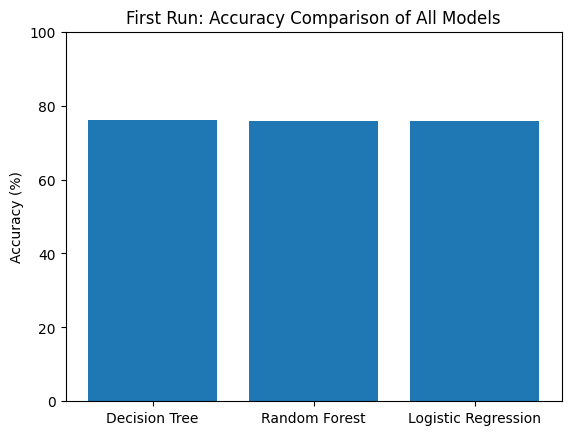

In [ ]:

dt_acc_1 = result.output_for_node("decision_tree_model")["accuracy"] * 100
rf_acc_1 = result.output_for_node("random_forest_model")["accuracy"] * 100
lr_acc_1 = result.output_for_node("logistic_regression_model")["accuracy"] * 100

models = ["Decision Tree", "Random Forest", "Logistic Regression"]
acc_run1 = [dt_acc_1, rf_acc_1, lr_acc_1]

print("FIRST RUN ACCURACY (%)")
print("Decision Tree      :", round(dt_acc_1, 2))
print("Random Forest      :", round(rf_acc_1, 2))
print("Logistic Regression:", round(lr_acc_1, 2))

import matplotlib.pyplot as plt

plt.figure()
plt.bar(models, acc_run1)
plt.ylabel("Accuracy (%)")
plt.title("First Run: Accuracy Comparison of All Models")
plt.ylim(0, 100)
plt.show()



In [ ]:
# --- MODIFY DATASET FOR SECOND RUN ---
df = pd.read_csv("AB_NYC_2019.csv")

# Remove 20% of rows (simulating new / changed data)
df = df.sample(frac=0.8, random_state=42)

# Save modified dataset
df.to_csv("AB_NYC_2019.csv", index=False)

print("Dataset modified: 20% data removed")


Dataset modified: 20% data removed


In [ ]:
# --- SECOND RUN: ONLY BEST MODEL ---
result_run2 = materialize([
    raw_data,
    cleaned_data,
    features,
    train_test_data,
    decision_tree_model,
])

dt_acc_run2 = result_run2.output_for_node("decision_tree_model")["accuracy"] * 100

print("SECOND RUN ACCURACY (%)")
print(f"Decision Tree (After Data Change): {dt_acc_run2:.2f}%")


2026-01-31 07:51:30 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 001e545c-11ff-4a97-83ae-7887249e082f - 4318 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-01-31 07:51:30 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 001e545c-11ff-4a97-83ae-7887249e082f - 4318 - ENGINE_EVENT - Executing steps in process (pid: 4318)
2026-01-31 07:51:30 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 001e545c-11ff-4a97-83ae-7887249e082f - 4318 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 07:51:30 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 001e545c-11ff-4a97-83ae-7887249e082f - 4318 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 07:51:30 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 001e545c-11ff-4a97-83ae-7887249e082f - 4318 - LOGS_CAPTURED - Started capturing logs in process (pid: 4318).
2026-01-31 07:51:30 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 001

SECOND RUN ACCURACY (%)
Decision Tree (After Data Change): 82.06%


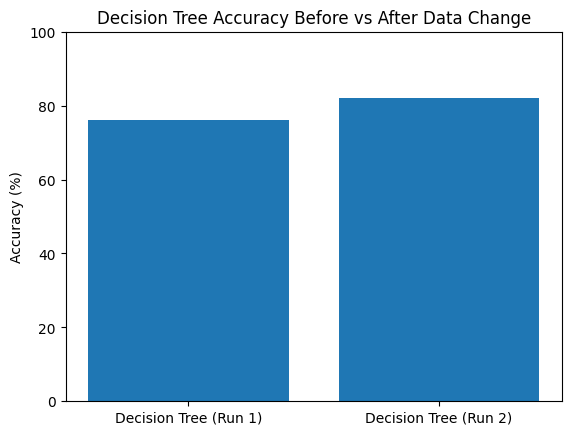

In [ ]:
import matplotlib.pyplot as plt

# --- Get Run 1 accuracy safely ---
dt_acc_run1 = result.output_for_node("decision_tree_model")["accuracy"] * 100

# --- Get Run 2 accuracy safely ---
dt_acc_run2 = result_run2.output_for_node("decision_tree_model")["accuracy"] * 100

labels = ["Decision Tree (Run 1)", "Decision Tree (Run 2)"]
values = [dt_acc_run1, dt_acc_run2]

plt.figure()
plt.bar(labels, values)
plt.ylabel("Accuracy (%)")
plt.title("Decision Tree Accuracy Before vs After Data Change")
plt.ylim(0, 100)
plt.show()


In [ ]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

start_no_dagster = time.time()

# Full pipeline (manual, no Dagster)
df = pd.read_csv("AB_NYC_2019.csv")
df = df.dropna(subset=["price", "room_type", "neighbourhood_group"])
df["minimum_nights"] = df["minimum_nights"].fillna(df["minimum_nights"].median())

df["price_category"] = pd.cut(
    df["price"], bins=[0, 100, 300, 10000],
    labels=["Cheap", "Medium", "Expensive"]
)
df = df.dropna(subset=["price_category"])

le1, le2 = LabelEncoder(), LabelEncoder()
df["room_type_enc"] = le1.fit_transform(df["room_type"])
df["area_enc"] = le2.fit_transform(df["neighbourhood_group"])

X = df[["room_type_enc", "area_enc", "minimum_nights"]]
y = df["price_category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

DecisionTreeClassifier().fit(X_train, y_train)
RandomForestClassifier(n_estimators=50).fit(X_train, y_train)
LogisticRegression(max_iter=300).fit(X_train, y_train)

time_no_dagster_min = (time.time() - start_no_dagster) / 60

print(f"Time WITHOUT Dagster (Full Pipeline): {time_no_dagster_min:.3f} minutes")


Time WITHOUT Dagster (Full Pipeline): 0.049 minutes


In [ ]:
import time
from dagster import materialize

start_dagster = time.time()

# Only required assets for best model (Decision Tree)
materialize([
    raw_data,
    cleaned_data,
    features,
    train_test_data,
    decision_tree_model
])

time_dagster_min = (time.time() - start_dagster) / 60

print(f"Time WITH Dagster (Selective Execution): {time_dagster_min:.3f} minutes")


2026-01-31 07:58:57 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 1143bfb1-10d8-466d-8086-d787b8832cb9 - 4318 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-01-31 07:58:57 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 1143bfb1-10d8-466d-8086-d787b8832cb9 - 4318 - ENGINE_EVENT - Executing steps in process (pid: 4318)
2026-01-31 07:58:57 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 1143bfb1-10d8-466d-8086-d787b8832cb9 - 4318 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 07:58:57 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 1143bfb1-10d8-466d-8086-d787b8832cb9 - 4318 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 07:58:57 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 1143bfb1-10d8-466d-8086-d787b8832cb9 - 4318 - LOGS_CAPTURED - Started capturing logs in process (pid: 4318).
2026-01-31 07:58:57 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 114

Time WITH Dagster (Selective Execution): 0.019 minutes


In [ ]:
print("EXECUTION TIME COMPARISON (IN MINUTES)")
print("-------------------------------------")
print(f"Without Dagster (All Models) : {time_no_dagster_min:.3f} minutes")
print(f"With Dagster (Best Model)    : {time_dagster_min:.3f} minutes")
print(f"Time Saved Using Dagster     : {(time_no_dagster_min - time_dagster_min):.3f} minutes")


EXECUTION TIME COMPARISON (IN MINUTES)
-------------------------------------
Without Dagster (All Models) : 0.049 minutes
With Dagster (Best Model)    : 0.019 minutes
Time Saved Using Dagster     : 0.030 minutes


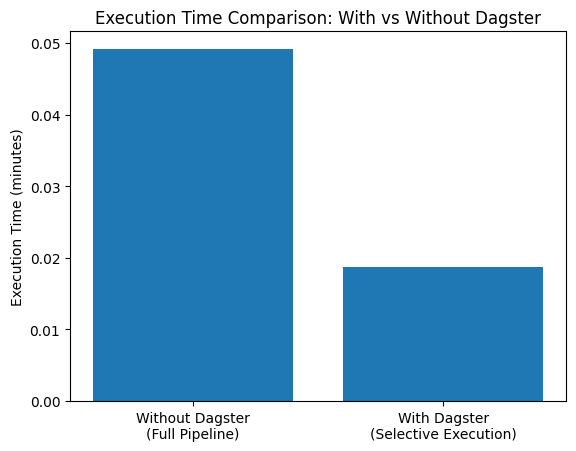

In [ ]:
import matplotlib.pyplot as plt

labels = ["Without Dagster\n(Full Pipeline)", "With Dagster\n(Selective Execution)"]
times = [time_no_dagster_min, time_dagster_min]

plt.figure()
plt.bar(labels, times)
plt.ylabel("Execution Time (minutes)")
plt.title("Execution Time Comparison: With vs Without Dagster")
plt.show()
